In [1]:
import pandas as pd
import numpy as np
from federated_learning.coordinator import FederatedLearning
from federated_learning.models.logistic_v2 import LogisticModel_Stat
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score

In [2]:
def run_federated_learning(
    file_paths,
    features=['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex'],
    target='Sinistre',
    num_rounds=1,
    alpha=0.1,
    visualize=True
):
    try:
        data_dict = {}
        for client_name, path in file_paths.items():
            df = pd.read_csv(path)
            print(f"Données chargées pour {client_name}: {len(df)} lignes")

            # Normalisation des variables numériques
            numeric_cols = df[features].select_dtypes(include=[float, int]).columns
            print(f"Normalisation des variables numériques pour {client_name}: {list(numeric_cols)}")
            df[numeric_cols] = StandardScaler().fit_transform(df[numeric_cols])

            data_dict[client_name] = df

        # Initialisation du système fédéré
        print("\nConfiguration du système d'apprentissage fédéré...")
        print(f"[DEBUG run_federated_learning] alpha transmis = {alpha}")
        fl = FederatedLearning(
            data_dict=data_dict,
            features=features,
            target=target,
            model_class=LogisticModel_Stat,
            alpha=alpha  # Assurez-vous que alpha est passé correctement
        )
        fl.setup()

        print("\nDémarrage de l'entraînement fédéré...")
        global_weights = fl.train(num_rounds=num_rounds)
        feature_names = ['Intercept'] + features

        print("\nPoids globaux finaux :")
        for name, weight in zip(feature_names, global_weights):
            print(f"  {name}: {weight:.6f}")

        clients_weights = {
            client.name: client.model.get_weights()
            for client in fl.server.clients
            if hasattr(client.model, 'get_weights')
        }

        if visualize:
            fl.plot_model_coefficients()
            fl.compare_local_vs_global_roc()
            fl.compare_local_vs_global_pr()
            fl.compare_cross_client_performance()

        return global_weights, clients_weights, feature_names, fl

    except Exception as e:
        print(f"[Erreur] exécution interrompue : {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None


In [3]:
file_paths = {
    #'Client Fr': 'data/french_data.csv',
    'Client BE': 'data/belgium_data.csv',
    'Client EU': 'data/european_data.csv'
}
#run_federated_learning(file_paths)

In [4]:
from sklearn.linear_model import LogisticRegression

def run_multiple_alphas_with_metrics(
    file_paths,
    alpha_values=[0.0, 0.01, 0.1, 0.5, 1.0, 10.0, 100.0],
    features=['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex'],
    target='Sinistre',
    num_rounds=1
):
    all_weights = []
    all_norms = []
    metrics_f1 = []
    metrics_auc = []

    for alpha in alpha_values:
        print('@@@@@@@@@@@@@@@@@@', alpha, '@@@@@@@@@@@@@@@@@@@@@@@@@')
        print(f"\n==== Entraînement avec alpha = {alpha} ====")
        global_weights, clients_weights, feature_names, fl = run_federated_learning(
            file_paths=file_paths,
            features=features,
            target=target,
            num_rounds=num_rounds,
            alpha=alpha,
            visualize=False
        )

        if global_weights is None:
            continue

        all_weights.append(global_weights)
        norm = np.linalg.norm(global_weights)
        all_norms.append(norm)
        print(f"[INFO] Norme L2 des poids globaux (alpha={alpha}) : {norm:.4f}")

        f1_list = []
        auc_list = []

        for client in fl.server.clients:
            model = LogisticModel_Stat(alpha=alpha)  # Ceci est correct
            
            # Ne pas entraîner le modèle avant de définir les poids
            # Au lieu de cela, initialiser correctement le modèle
            model.model = LogisticRegression(
                penalty='l2',
                C=1.0 / alpha if alpha > 0 else 1e12,
                solver='lbfgs',
                max_iter=1000,
                fit_intercept=True
            )
            model.fitted = True
            model.set_weights(global_weights)
            
            y_true = client.y_test
            y_proba = model.predict_proba(client.X_test)
            if y_proba.ndim > 1:
                y_proba = y_proba[:, 1]
            y_pred = (y_proba >= 0.5).astype(int)

            f1 = f1_score(y_true, y_pred)
            auc = roc_auc_score(y_true, y_proba)
            f1_list.append(f1)
            auc_list.append(auc)

        metrics_f1.append(np.mean(f1_list))
        metrics_auc.append(np.mean(auc_list))

    # Tracé des coefficients
    weight_matrix = np.vstack(all_weights)
    plt.figure(figsize=(10, 6))
    for i, name in enumerate(feature_names):
        plt.plot(alpha_values, weight_matrix[:, i], label=name, marker='o')
    plt.xlabel("alpha (régularisation Ridge)")
    plt.ylabel("Coefficient global")
    plt.title("Évolution des coefficients selon alpha")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Norme L2
    plt.figure(figsize=(8, 4))
    plt.plot(alpha_values, all_norms, marker='s')
    plt.title("Norme L2 des poids globaux selon alpha")
    plt.xlabel("alpha")
    plt.ylabel("||w||")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # F1 / AUC
    plt.figure(figsize=(8, 4))
    plt.plot(alpha_values, metrics_f1, marker='o', label="F1-score")
    plt.plot(alpha_values, metrics_auc, marker='^', label="AUC", linestyle='--')
    plt.title("Évolution des performances globales selon alpha")
    plt.xlabel("alpha")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "alphas": alpha_values,
        "weights": weight_matrix,
        "norms": all_norms,
        "f1": metrics_f1,
        "auc": metrics_auc,
        "features": feature_names
    }


@@@@@@@@@@@@@@@@@@ 0.0 @@@@@@@@@@@@@@@@@@@@@@@@@

==== Entraînement avec alpha = 0.0 ====
Données chargées pour Client BE: 163212 lignes
Normalisation des variables numériques pour Client BE: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']
Données chargées pour Client EU: 2373197 lignes
Normalisation des variables numériques pour Client EU: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']

Configuration du système d'apprentissage fédéré...
[DEBUG run_federated_learning] alpha transmis = 0.0
[DEBUG FederatedLearning.__init__] Paramètres reçus: {'alpha': 0.0}
Configuration du client 'Client BE' avec 163212 observations
Nettoyage des données pour Client BE (NaN ou inf)...
 => 163212 lignes restantes après nettoyage
[DEBUG setup] Création du modèle avec paramètres: {'alpha': 0.0}
[DEBUG LogisticModel_SKL] Initialisation avec alpha = 0.0
Client 'Client BE' ajouté avec succès
Configuration du client 'Client EU' avec 2373197 observations
Nettoyage des données pour Client EU (NaN ou

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Données chargées pour Client BE: 163212 lignes
Normalisation des variables numériques pour Client BE: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']
Données chargées pour Client EU: 2373197 lignes
Normalisation des variables numériques pour Client EU: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']

Configuration du système d'apprentissage fédéré...
[DEBUG run_federated_learning] alpha transmis = 0.01
[DEBUG FederatedLearning.__init__] Paramètres reçus: {'alpha': 0.01}
Configuration du client 'Client BE' avec 163212 observations
Nettoyage des données pour Client BE (NaN ou inf)...
 => 163212 lignes restantes après nettoyage
[DEBUG setup] Création du modèle avec paramètres: {'alpha': 0.01}
[DEBUG LogisticModel_SKL] Initialisation avec alpha = 0.01
Client 'Client BE' ajouté avec succès
Configuration du client 'Client EU' avec 2373197 observations
Nettoyage des données pour Client EU (NaN ou inf)...
 => 2372377 lignes restantes après nettoyage
[DEBUG setup] Création du modèle

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


@@@@@@@@@@@@@@@@@@ 0.1 @@@@@@@@@@@@@@@@@@@@@@@@@

==== Entraînement avec alpha = 0.1 ====
Données chargées pour Client BE: 163212 lignes
Normalisation des variables numériques pour Client BE: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']
Données chargées pour Client EU: 2373197 lignes
Normalisation des variables numériques pour Client EU: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']

Configuration du système d'apprentissage fédéré...
[DEBUG run_federated_learning] alpha transmis = 0.1
[DEBUG FederatedLearning.__init__] Paramètres reçus: {'alpha': 0.1}
Configuration du client 'Client BE' avec 163212 observations
Nettoyage des données pour Client BE (NaN ou inf)...
 => 163212 lignes restantes après nettoyage
[DEBUG setup] Création du modèle avec paramètres: {'alpha': 0.1}
[DEBUG LogisticModel_SKL] Initialisation avec alpha = 0.1
Client 'Client BE' ajouté avec succès
Configuration du client 'Client EU' avec 2373197 observations
Nettoyage des données pour Client EU (NaN ou

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Données chargées pour Client BE: 163212 lignes
Normalisation des variables numériques pour Client BE: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']
Données chargées pour Client EU: 2373197 lignes
Normalisation des variables numériques pour Client EU: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']

Configuration du système d'apprentissage fédéré...
[DEBUG run_federated_learning] alpha transmis = 0.5
[DEBUG FederatedLearning.__init__] Paramètres reçus: {'alpha': 0.5}
Configuration du client 'Client BE' avec 163212 observations
Nettoyage des données pour Client BE (NaN ou inf)...
 => 163212 lignes restantes après nettoyage
[DEBUG setup] Création du modèle avec paramètres: {'alpha': 0.5}
[DEBUG LogisticModel_SKL] Initialisation avec alpha = 0.5
Client 'Client BE' ajouté avec succès
Configuration du client 'Client EU' avec 2373197 observations
Nettoyage des données pour Client EU (NaN ou inf)...
 => 2372377 lignes restantes après nettoyage
[DEBUG setup] Création du modèle ave

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Données chargées pour Client BE: 163212 lignes
Normalisation des variables numériques pour Client BE: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']
Données chargées pour Client EU: 2373197 lignes
Normalisation des variables numériques pour Client EU: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']

Configuration du système d'apprentissage fédéré...
[DEBUG run_federated_learning] alpha transmis = 1.0
[DEBUG FederatedLearning.__init__] Paramètres reçus: {'alpha': 1.0}
Configuration du client 'Client BE' avec 163212 observations
Nettoyage des données pour Client BE (NaN ou inf)...
 => 163212 lignes restantes après nettoyage
[DEBUG setup] Création du modèle avec paramètres: {'alpha': 1.0}
[DEBUG LogisticModel_SKL] Initialisation avec alpha = 1.0
Client 'Client BE' ajouté avec succès
Configuration du client 'Client EU' avec 2373197 observations
Nettoyage des données pour Client EU (NaN ou inf)...
 => 2372377 lignes restantes après nettoyage
[DEBUG setup] Création du modèle ave

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


@@@@@@@@@@@@@@@@@@ 10.0 @@@@@@@@@@@@@@@@@@@@@@@@@

==== Entraînement avec alpha = 10.0 ====
Données chargées pour Client BE: 163212 lignes
Normalisation des variables numériques pour Client BE: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']
Données chargées pour Client EU: 2373197 lignes
Normalisation des variables numériques pour Client EU: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']

Configuration du système d'apprentissage fédéré...
[DEBUG run_federated_learning] alpha transmis = 10.0
[DEBUG FederatedLearning.__init__] Paramètres reçus: {'alpha': 10.0}
Configuration du client 'Client BE' avec 163212 observations
Nettoyage des données pour Client BE (NaN ou inf)...
 => 163212 lignes restantes après nettoyage
[DEBUG setup] Création du modèle avec paramètres: {'alpha': 10.0}
[DEBUG LogisticModel_SKL] Initialisation avec alpha = 10.0
Client 'Client BE' ajouté avec succès
Configuration du client 'Client EU' avec 2373197 observations
Nettoyage des données pour Client EU (

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Données chargées pour Client BE: 163212 lignes
Normalisation des variables numériques pour Client BE: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']
Données chargées pour Client EU: 2373197 lignes
Normalisation des variables numériques pour Client EU: ['Power', 'DriverAge', 'Fuel_type', 'Density', 'Sex']

Configuration du système d'apprentissage fédéré...
[DEBUG run_federated_learning] alpha transmis = 100.0
[DEBUG FederatedLearning.__init__] Paramètres reçus: {'alpha': 100.0}
Configuration du client 'Client BE' avec 163212 observations
Nettoyage des données pour Client BE (NaN ou inf)...
 => 163212 lignes restantes après nettoyage
[DEBUG setup] Création du modèle avec paramètres: {'alpha': 100.0}
[DEBUG LogisticModel_SKL] Initialisation avec alpha = 100.0
Client 'Client BE' ajouté avec succès
Configuration du client 'Client EU' avec 2373197 observations
Nettoyage des données pour Client EU (NaN ou inf)...
 => 2372377 lignes restantes après nettoyage
[DEBUG setup] Création du mo

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


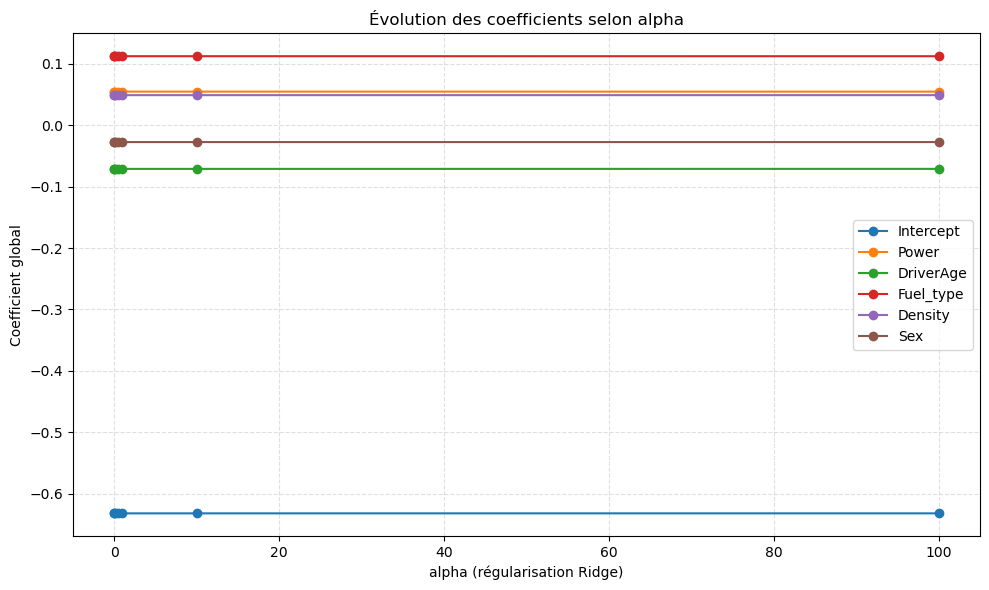

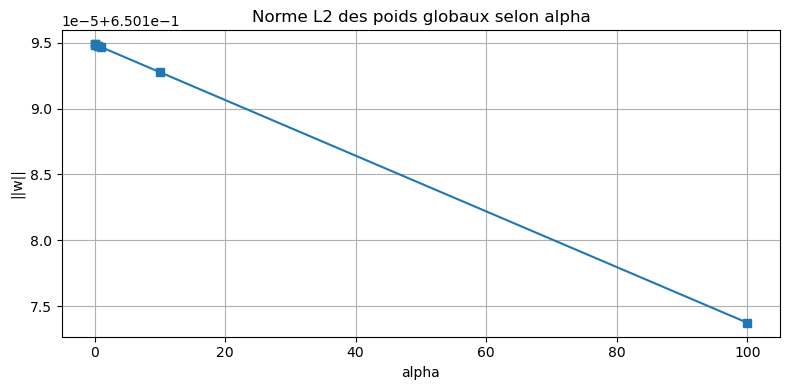

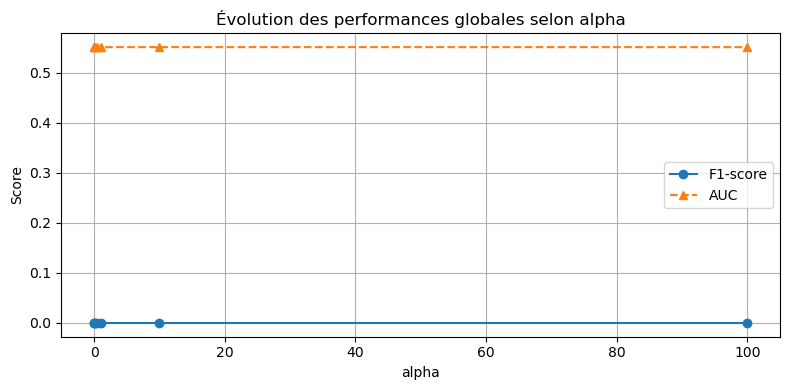

{'alphas': [0.0, 0.01, 0.1, 0.5, 1.0, 10.0, 100.0],
 'weights': array([[-0.63167601,  0.05442792, -0.07129086,  0.11206451,  0.04868786,
         -0.02765939],
        [-0.63167601,  0.05442792, -0.07129086,  0.1120645 ,  0.04868786,
         -0.02765939],
        [-0.63167601,  0.05442791, -0.07129082,  0.11206447,  0.04868784,
         -0.02765937],
        [-0.63167598,  0.05442787, -0.07129066,  0.1120643 ,  0.04868772,
         -0.02765932],
        [-0.63167595,  0.05442783, -0.07129046,  0.1120641 ,  0.04868757,
         -0.02765924],
        [-0.63167537,  0.05442704, -0.07128686,  0.11206047,  0.04868493,
         -0.02765796],
        [-0.63166958,  0.05441916, -0.0712509 ,  0.11202415,  0.04865853,
         -0.02764513]]),
 'norms': [np.float64(0.6501948757315612),
  np.float64(0.6501948736150424),
  np.float64(0.6501948545664081),
  np.float64(0.6501947699065592),
  np.float64(0.6501946640834658),
  np.float64(0.6501927595940632),
  np.float64(0.6501737485999033)],
 'f1': [

In [5]:
file_paths = {
    #'Client Fr': 'data/french_data.csv',
    'Client BE': 'data/belgium_data.csv',
    'Client EU': 'data/european_data.csv'
}

run_multiple_alphas_with_metrics(file_paths)
